In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [5]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [6]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    '../mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    '../mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:17<00:00, 566kB/s] 


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 42.3kB/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:08<00:00, 196kB/s] 


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.86MB/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [23]:
def train(model, optimizer, criterion=nn.CrossEntropyLoss(), n_epochs=5):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in range(n_epochs):
        train_batch_losses = []
        train_batch_accs = []
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_batch_losses.append(loss.item())
            train_batch_accs.extend((torch.argmax(y_pred, dim=-1)==y_train).numpy().tolist())
        train_losses.append(np.mean(train_batch_losses))
        train_accs.append(np.mean(train_batch_accs))
        with torch.no_grad():
            val_batch_losses = []
            val_batch_accs = []
            for x_val, y_val in tqdm(val_dataloader):
                y_pred = model(x_val)
                loss = criterion(y_pred, y_val)
                val_batch_losses.append(loss.item())
                val_batch_accs.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
            val_losses.append(np.mean(val_batch_losses))
            val_accs.append(np.mean(val_batch_accs))
            print(f'Epoch: {epoch}, val_loss: {val_losses[-1]}, val_accuracy: {val_accs[-1]}')
    return train_losses, train_accs, val_losses, val_accs

In [24]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [17]:
baseline = train(model, optimizer)

100%|██████████| 157/157 [00:05<00:00, 27.94it/s]


Epoch: 0, val_loss: 0.3175366187741043, val_accuracy: 0.9104


100%|██████████| 157/157 [00:05<00:00, 26.25it/s]


Epoch: 1, val_loss: 0.2666431607524301, val_accuracy: 0.9228


100%|██████████| 157/157 [00:08<00:00, 19.20it/s]


Epoch: 2, val_loss: 0.22727702297033017, val_accuracy: 0.9322


100%|██████████| 157/157 [00:07<00:00, 22.00it/s]


Epoch: 3, val_loss: 0.20410361990427514, val_accuracy: 0.9408


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]

Epoch: 4, val_loss: 0.1827433133011411, val_accuracy: 0.947


In [27]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [19]:
def draw_graphics(train_losses, train_accs, val_losses, val_accs, title):
    epochs = range(1, len(train_losses)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title)
    ax1.plot(epochs, train_losses, 'r', label='Train loss')
    ax1.plot(epochs, val_losses, 'b', label='Val loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_accs, 'r', label='Train accuracy')
    ax2.plot(epochs, val_accs, 'b', label='Val accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
def count_parameters(model):
    return sum(pars.numel() for pars in model.parameters() if pars.requires_grad)

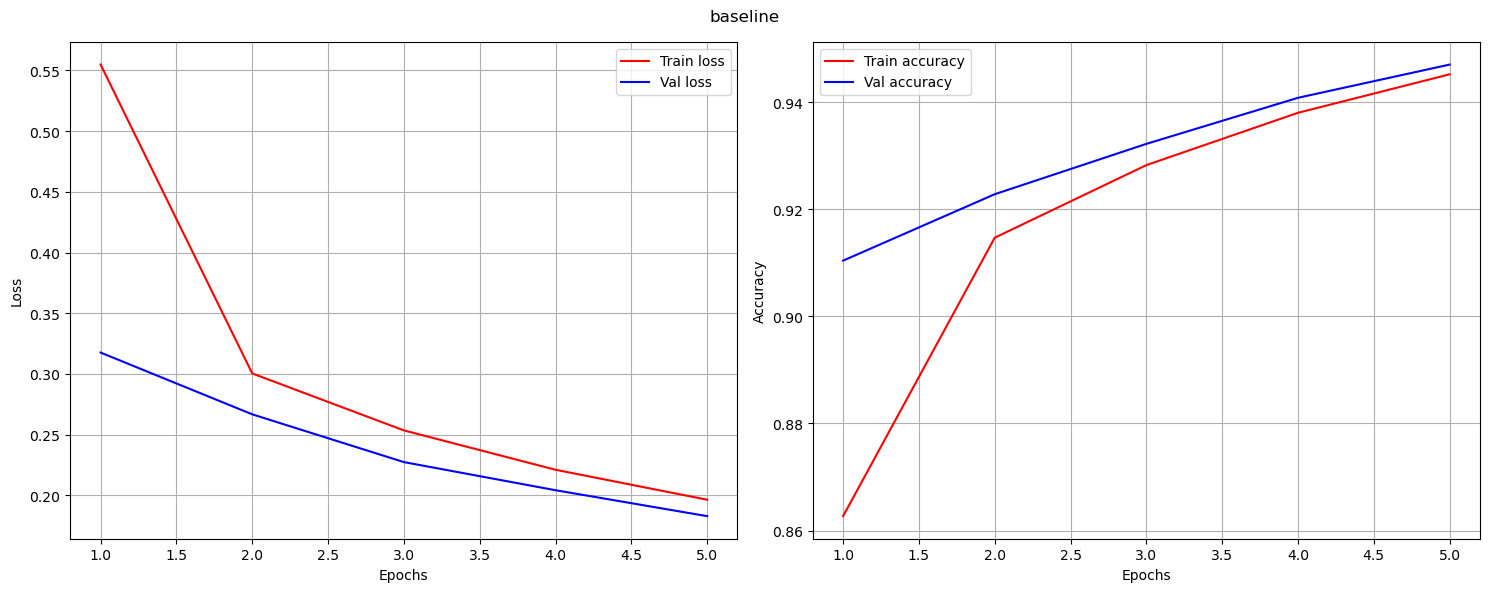

In [20]:
draw_graphics(*baseline, 'baseline')

In [8]:
optimizer = torch.optim.AdamW(model.parameters())

100%|██████████| 157/157 [00:07<00:00, 20.92it/s]


Epoch: 0, val_loss: 0.16867313284877758, val_accuracy: 0.9518


100%|██████████| 157/157 [00:06<00:00, 26.10it/s]


Epoch: 1, val_loss: 0.15542393768574023, val_accuracy: 0.9553


100%|██████████| 157/157 [00:08<00:00, 18.87it/s]


Epoch: 2, val_loss: 0.14389223543701657, val_accuracy: 0.9592


100%|██████████| 157/157 [00:06<00:00, 24.31it/s]


Epoch: 3, val_loss: 0.13682021930291774, val_accuracy: 0.9607


100%|██████████| 157/157 [00:06<00:00, 25.89it/s]


Epoch: 4, val_loss: 0.1290979705347567, val_accuracy: 0.9623


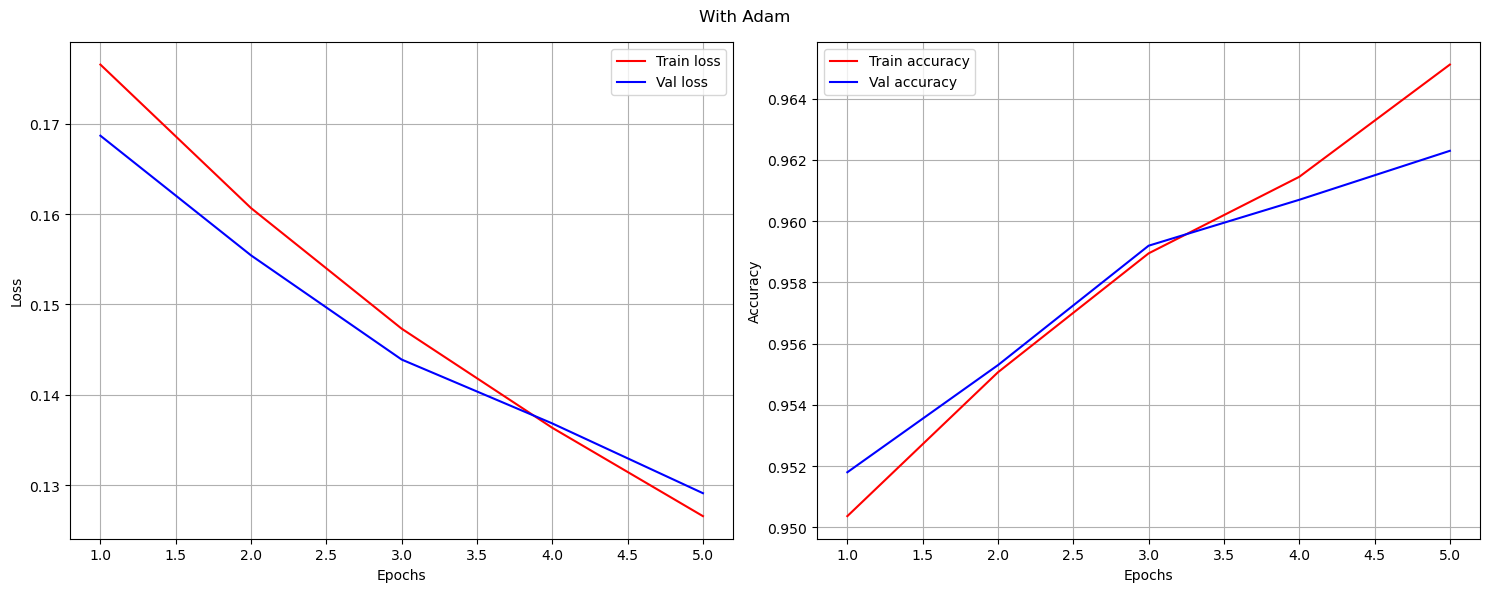

In [21]:
adam = train(model, optimizer)
draw_graphics(*adam, 'With Adam')

In [24]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters())

100%|██████████| 157/157 [00:19<00:00,  8.07it/s]


Epoch: 0, val_loss: 1.619591975667674, val_accuracy: 0.7067


100%|██████████| 157/157 [00:21<00:00,  7.47it/s]


Epoch: 1, val_loss: 0.737135276293299, val_accuracy: 0.8388


100%|██████████| 157/157 [00:19<00:00,  8.06it/s]


Epoch: 2, val_loss: 0.4894112200494025, val_accuracy: 0.8746


100%|██████████| 157/157 [00:19<00:00,  8.00it/s]


Epoch: 3, val_loss: 0.3923252005675796, val_accuracy: 0.8957


100%|██████████| 157/157 [00:20<00:00,  7.65it/s]


Epoch: 4, val_loss: 0.33866551765211067, val_accuracy: 0.9075


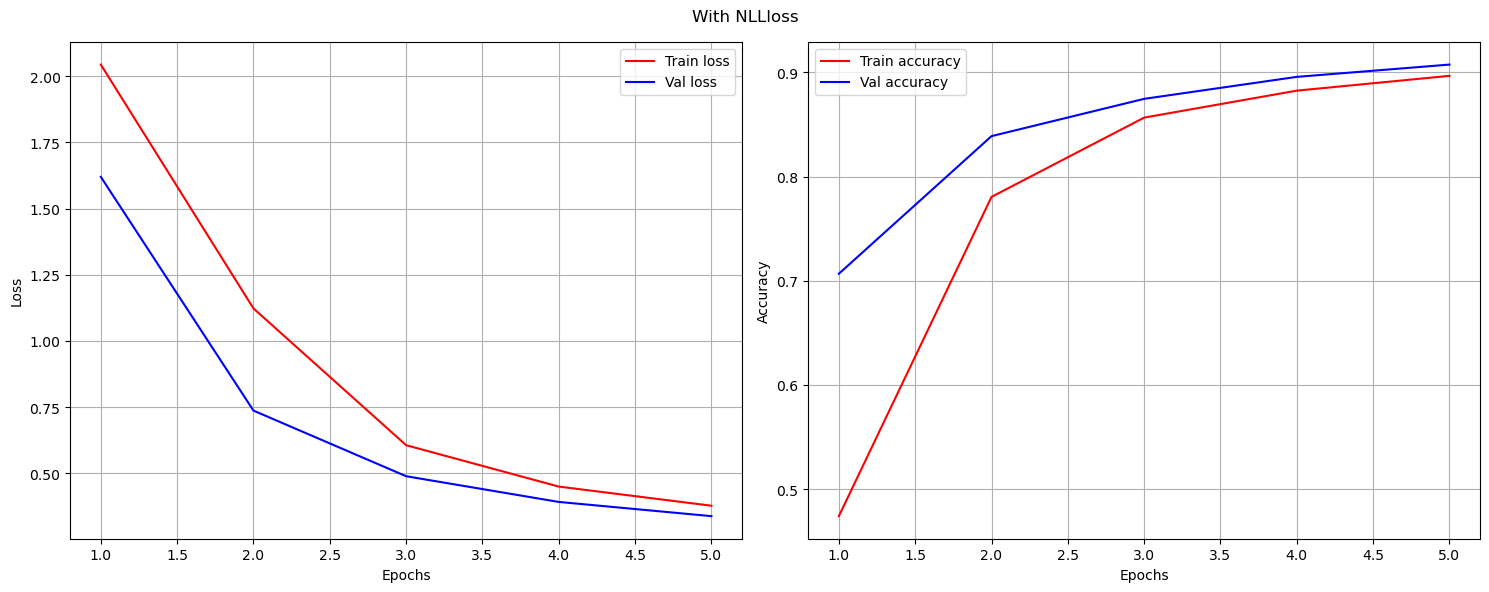

In [25]:
nllloss = train(model, optimizer, criterion)
draw_graphics(*nllloss, 'With NLLloss')

In [28]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*16, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer = torch.optim.SGD(model.parameters())

100%|██████████| 157/157 [00:35<00:00,  4.38it/s]


Epoch: 0, val_loss: 1.517626142805549, val_accuracy: 0.7615


100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


Epoch: 1, val_loss: 0.6635050815381821, val_accuracy: 0.8616


100%|██████████| 157/157 [00:41<00:00,  3.79it/s]


Epoch: 2, val_loss: 0.42492359136320224, val_accuracy: 0.8993


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Epoch: 3, val_loss: 0.3328519793832378, val_accuracy: 0.9179


100%|██████████| 157/157 [00:40<00:00,  3.92it/s]


Epoch: 4, val_loss: 0.2810501237014297, val_accuracy: 0.9261


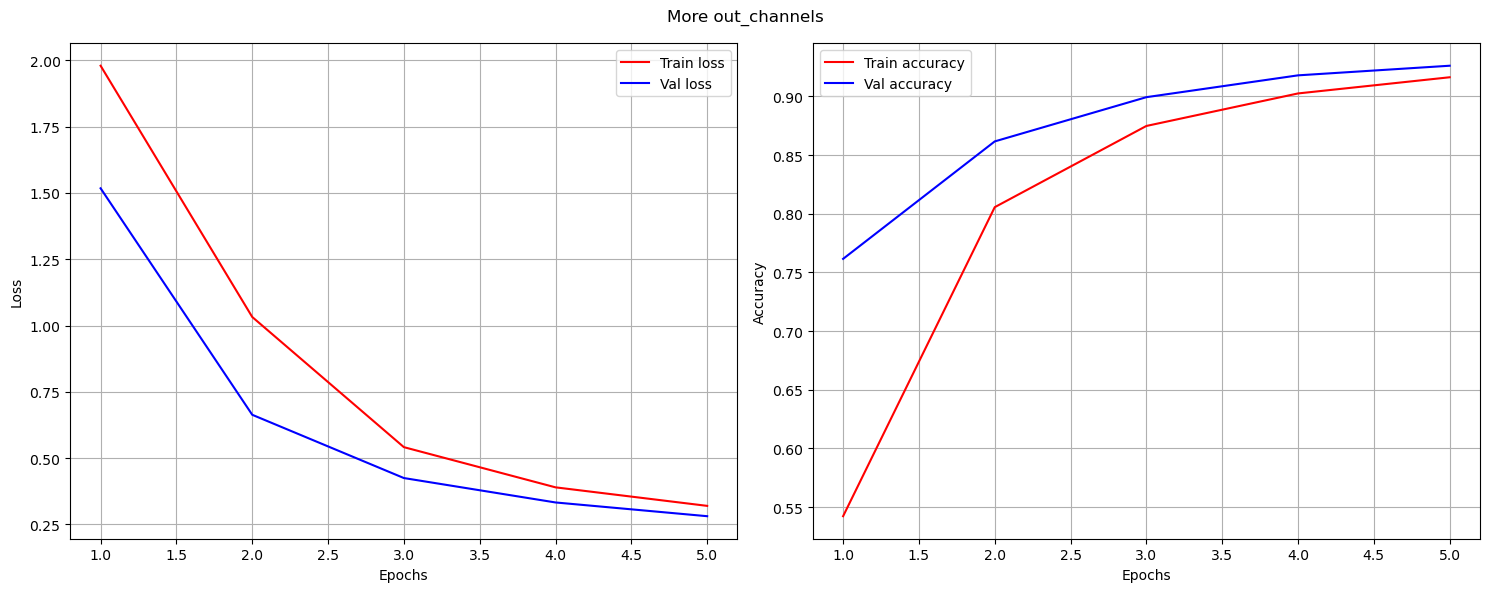

In [29]:
more_out_channels = train(model, optimizer)
draw_graphics(*more_out_channels, 'More out_channels')

In [34]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(12*12*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer = torch.optim.SGD(model.parameters())

100%|██████████| 157/157 [00:51<00:00,  3.06it/s]


Epoch: 0, val_loss: 0.9792504883875512, val_accuracy: 0.8244


100%|██████████| 157/157 [00:50<00:00,  3.11it/s]


Epoch: 1, val_loss: 0.4331211679300685, val_accuracy: 0.8944


100%|██████████| 157/157 [00:48<00:00,  3.22it/s]


Epoch: 2, val_loss: 0.3282723583423408, val_accuracy: 0.9127


100%|██████████| 157/157 [00:49<00:00,  3.18it/s]


Epoch: 3, val_loss: 0.280903391207859, val_accuracy: 0.9229


100%|██████████| 157/157 [00:50<00:00,  3.09it/s]


Epoch: 4, val_loss: 0.2528380913909074, val_accuracy: 0.9293


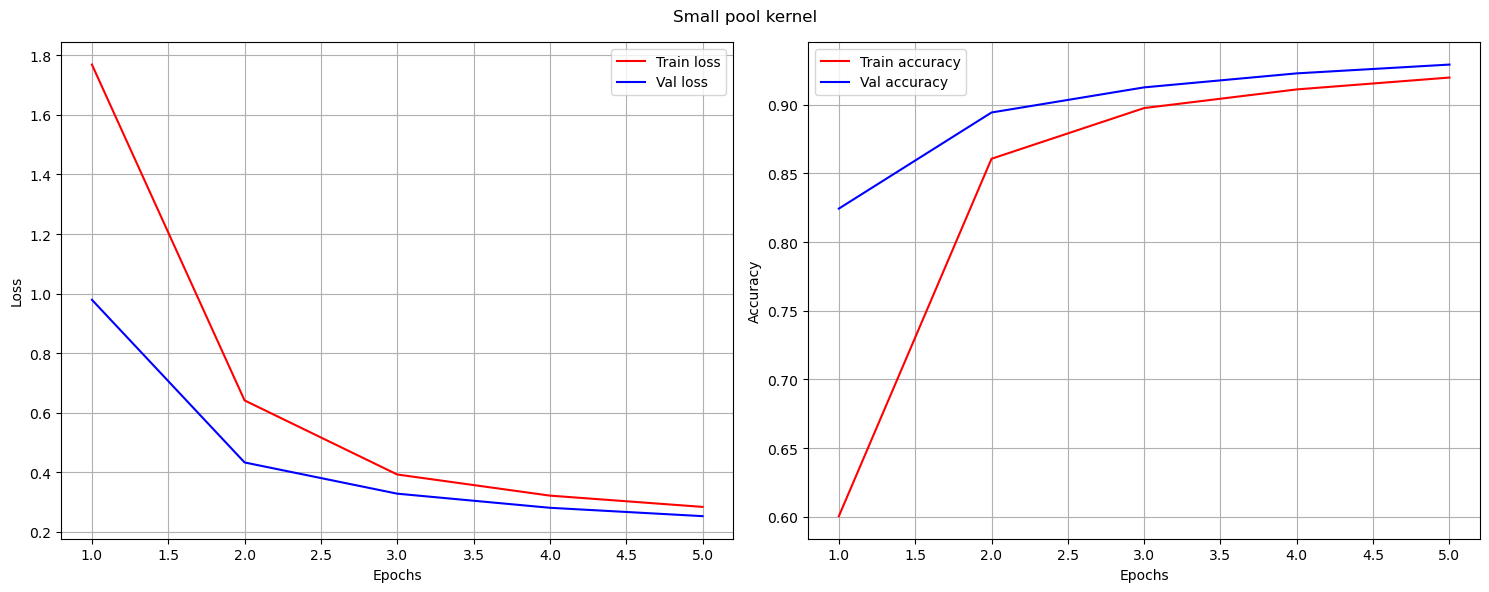

In [35]:
small_pool_kernel = train(model, optimizer)
draw_graphics(*small_pool_kernel, 'Small pool kernel')

In [36]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(12*12*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer = torch.optim.AdamW(model.parameters())

100%|██████████| 157/157 [00:20<00:00,  7.49it/s]


Epoch: 0, val_loss: 0.04125360908041631, val_accuracy: 0.9865


100%|██████████| 157/157 [00:21<00:00,  7.19it/s]


Epoch: 1, val_loss: 0.050098452556253247, val_accuracy: 0.9855


100%|██████████| 157/157 [00:22<00:00,  7.07it/s]


Epoch: 2, val_loss: 0.04848480696054353, val_accuracy: 0.9856


100%|██████████| 157/157 [00:21<00:00,  7.36it/s]


Epoch: 3, val_loss: 0.05112219446076037, val_accuracy: 0.987


100%|██████████| 157/157 [00:22<00:00,  6.91it/s]


Epoch: 4, val_loss: 0.04232340808198242, val_accuracy: 0.9876


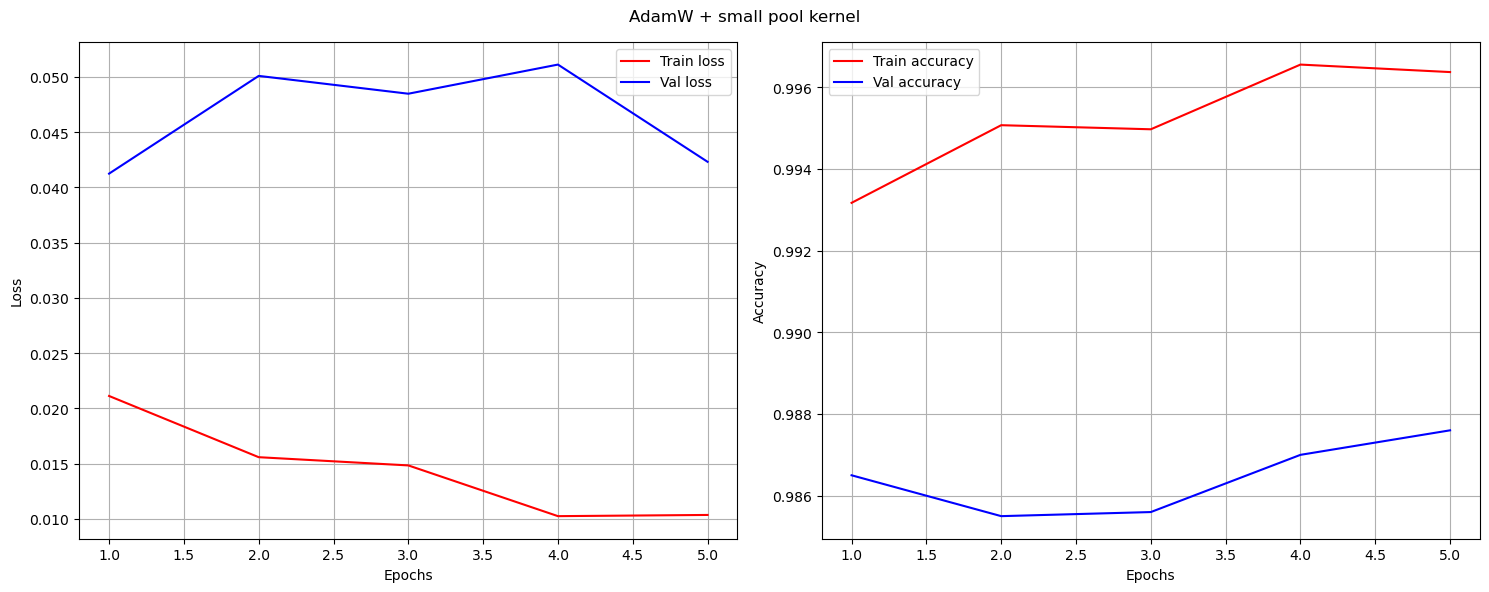

In [39]:
adam_small_pool_kernel = train(model, optimizer)
draw_graphics(*adam_small_pool_kernel, 'AdamW + small pool kernel')